<a href="https://colab.research.google.com/github/hanifa-8/Capstone-year_speciality_web/blob/main/finalipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os,warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
def set_seed(seed=14325):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(14325)

In [5]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

In [6]:
ds_train_ = image_dataset_from_directory(
    '/content/drive/MyDrive/dataset-20240706T123120Z-001/dataset/traning images',
    labels='inferred',
    label_mode='binary',
    image_size=[227, 227],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 679 files belonging to 2 classes.


In [7]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[227,227, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),



    layers.Dense(2, activation='softmax'),
])

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [11]:
ds_valid_ = image_dataset_from_directory(
    '/content/drive/MyDrive/dataset-20240706T123120Z-001/dataset/testing images',
    labels='inferred',
    label_mode='binary',
    image_size=[227,227],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)



Found 88 files belonging to 2 classes.


In [12]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=2,
)

Epoch 1/2
11/11 [==============================] - 244s 17s/step - loss: 0.6695 - accuracy: 0.6421 - val_loss: 0.6064 - val_accuracy: 0.7841
Epoch 2/2
11/11 [==============================] - 178s 16s/step - loss: 0.5198 - accuracy: 0.7953 - val_loss: 0.4981 - val_accuracy: 0.7727


In [13]:
ds_test_ = image_dataset_from_directory(
    '/content/drive/MyDrive/dataset-20240706T123120Z-001/dataset/testing images',
    labels='inferred',
    label_mode='binary',
    image_size=[227,227],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
ds_test = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 88 files belonging to 2 classes.


In [14]:
D="/content/drive/MyDrive/dataset-20240706T123120Z-001/dataset/testing images"
C=['fire','non fire']

In [15]:
import cv2

In [16]:
IMG_SIZE=227
data=[]
for c in C:
    f=os.path.join(D,c)
    label=C.index(c)
    for img in os.listdir(f):
        img_path=os.path.join(f,img)
        img_arr=cv2.imread(img_path)
        img_arr=cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE))
        data.append([img_arr,label])

X=[]
y=[]
for features,labels in data:
    X.append(features)
    y.append(labels)
X=np.array(X)
y=np.array(y)
X=X/255
X.shape

(88, 227, 227, 3)

In [17]:
k=model.predict(ds_valid)
yp=[np.argmax(e)for e in k]
print(yp)

2/2 [==============================] - 9s 2s/step
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
report = classification_report(y,yp)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.80        44
           1       0.90      0.61      0.73        44

    accuracy                           0.77        88
   macro avg       0.80      0.77      0.77        88
weighted avg       0.80      0.77      0.77        88



Text(9.444444444444452, 0.5, 'Truth')

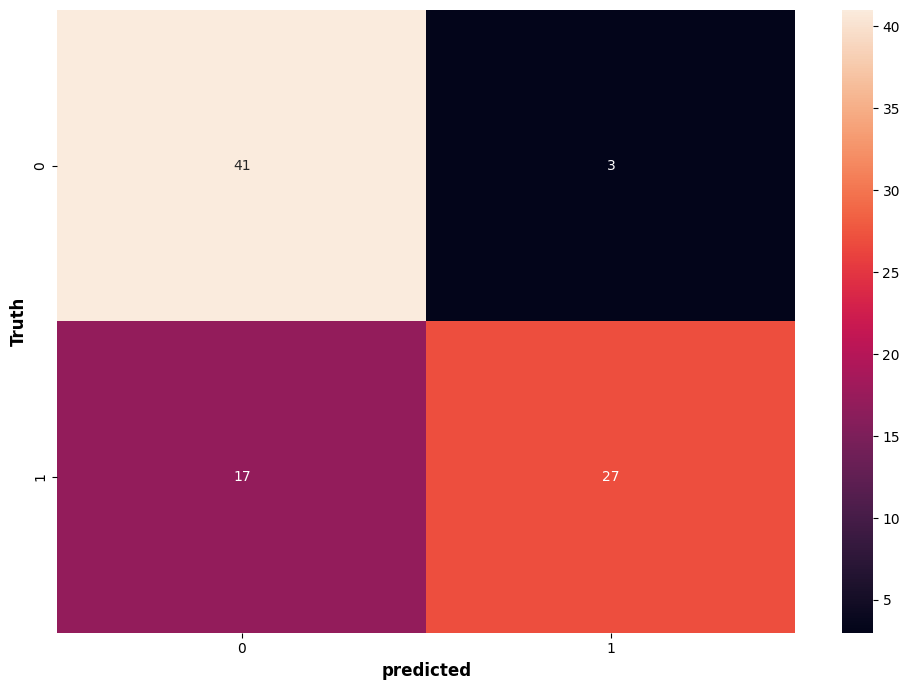

In [19]:
import tensorflow
cm=tensorflow.math.confusion_matrix(labels=y,predictions=yp)
cm
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')

In [20]:
# Save the model
model.save('fire_detection_model.h5')

In [21]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('fire_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)

1/1 [==============================] - 1s 601ms/step
Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_11_27_19_Pro.jpg, Predicted Label: fire


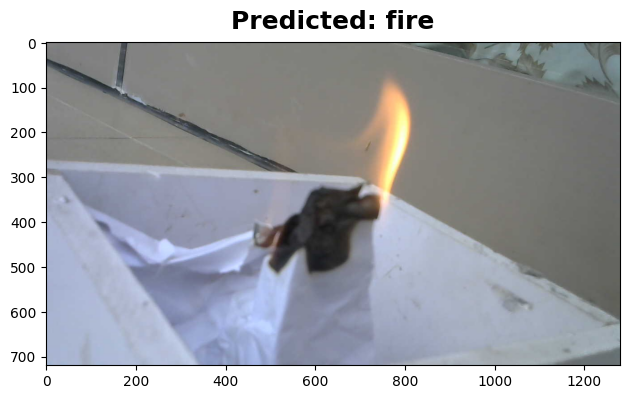

Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_10_34_39_Pro.jpg, Predicted Label: fire


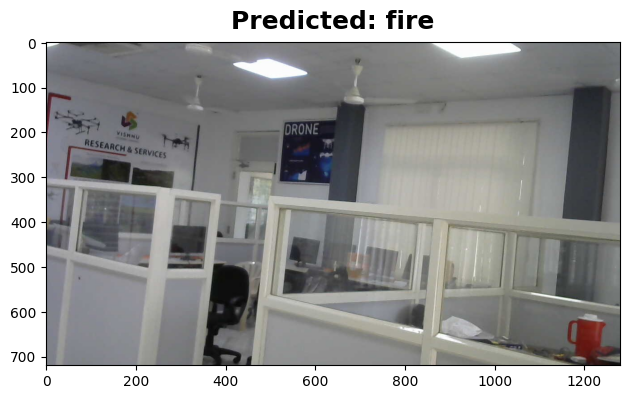

Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_11_40_03_Pro.jpg, Predicted Label: no fire


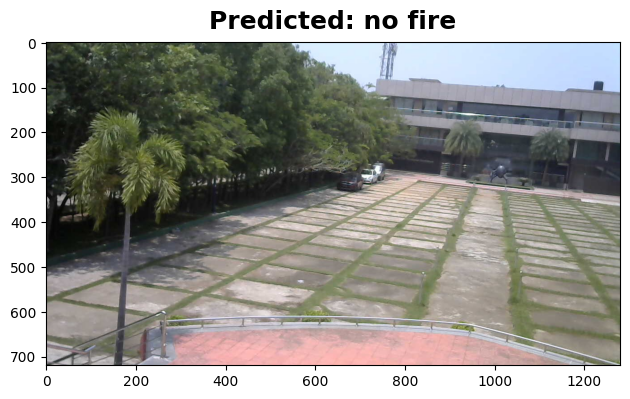

Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_14_14_19_Pro.jpg, Predicted Label: fire


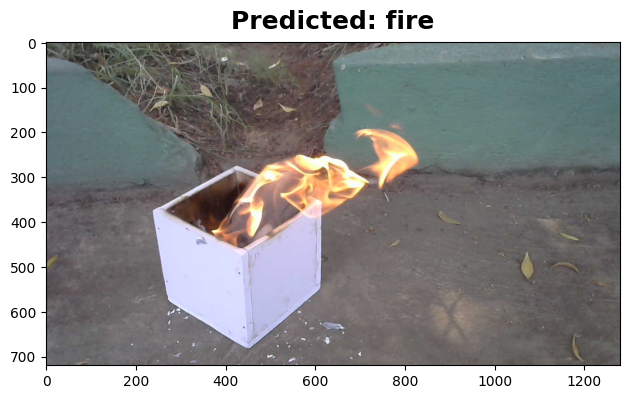

Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_11_36_17_Pro.jpg, Predicted Label: fire


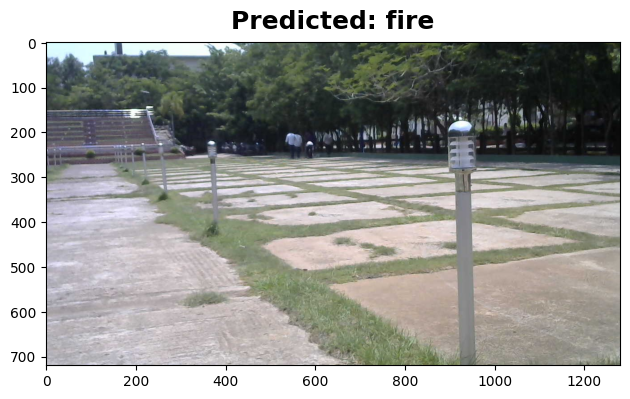

Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_15_42_44_Pro (2).jpg, Predicted Label: fire


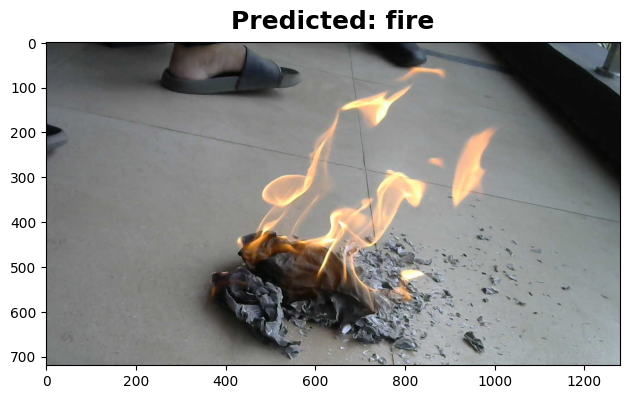

Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_11_37_06_Pro.jpg, Predicted Label: no fire


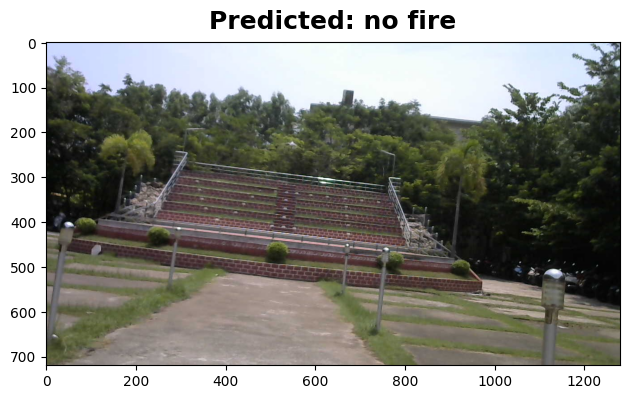

Image: /content/drive/MyDrive/input-20240706T165116Z-001/input/WIN_20240618_11_33_14_Pro.jpg, Predicted Label: fire


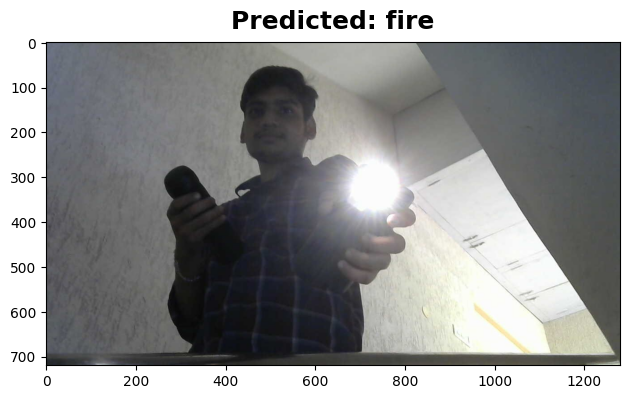

In [22]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/fire_detection_model.h5'

# Set the directory path for input images
input_images_dir = '/content/drive/MyDrive/input-20240706T165116Z-001/input'
IMG_SIZE = 227

# Load and preprocess the images
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    return img

# Function to make predictions on a set of images
def predict_fire_in_images(model, images_dir):
    images = []
    image_paths = []
    for img_name in os.listdir(images_dir):
        img_path = os.path.join(images_dir, img_name)
        image_paths.append(img_path)
        img = load_and_preprocess_image(img_path)
        images.append(img)

    images = np.array(images)
    predictions = model.predict(images)

    return predictions, image_paths

# Make predictions
predictions, image_paths = predict_fire_in_images(model, input_images_dir)

# Print the predictions
CATEGORIES = ['fire', 'no fire']
for img_path, prediction in zip(image_paths, predictions):
    predicted_label = CATEGORIES[np.argmax(prediction)]
    print(f"Image: {img_path}, Predicted Label: {predicted_label}")

    # Display the image with the prediction
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.show()
